#Предсказание BPM по другим свойствам аудиофайлов. Соревнование Kaggle

В данном ноутбуке представлено решение [задачи](https://www.kaggle.com/competitions/playground-series-s5e9) из 2025 Kaggle Playground Series. Представлен датасет с информацией о 500к аудиофайлов. Необходимо для тестовой выборки в 100к файлов предсказывать BPM.

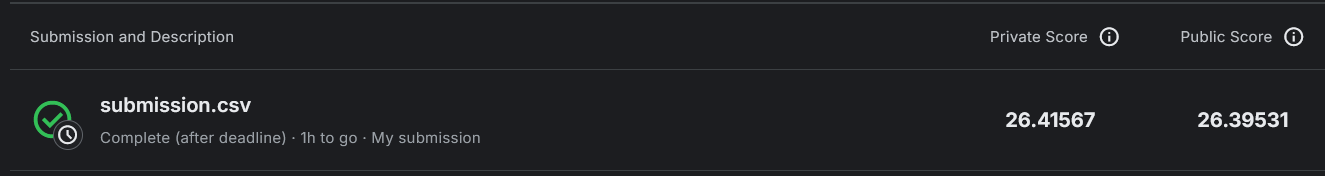

##Сбор данных

Установим библиотеку для скачивания датасета

In [3]:
!pip install -q opendatasets

Сохраним токен Kaggle в необходимых для opendatasets и kaggle submission директориях.

In [6]:
from google.colab import files
import shutil
import os

uploaded = files.upload()
os.makedirs('/root/.config/kaggle', exist_ok=True)
shutil.copy('kaggle.json', '/root/.config/kaggle/kaggle.json')

Saving kaggle.json to kaggle.json


'/root/.config/kaggle/kaggle.json'

Скачаем датасет.

In [7]:
import opendatasets as od

url = 'https://www.kaggle.com/competitions/playground-series-s5e9/data'
od.download(url)

100%|██████████| 33.3M/33.3M [00:00<00:00, 1.35GB/s]


Extracting archive ./playground-series-s5e9/playground-series-s5e9.zip to ./playground-series-s5e9


In [8]:
os.listdir('./playground-series-s5e9')

['sample_submission.csv', 'train.csv', 'test.csv']

##Исследование данных

Импортируем основные библиотеки для анализа данных.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
train = pd.read_csv('./playground-series-s5e9/train.csv')
test = pd.read_csv('./playground-series-s5e9/test.csv')

In [11]:
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


Пропуски отсутствуют.

In [12]:
train.isna().sum()

,0
id,0
RhythmScore,0
AudioLoudness,0
VocalContent,0
AcousticQuality,0
InstrumentalScore,0
LivePerformanceLikelihood,0
MoodScore,0
TrackDurationMs,0
Energy,0


В данных имеются выбросы.

In [13]:
train.describe()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,262081.500000,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,151313.257586,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.000000,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,131040.750000,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,262081.500000,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,393122.250000,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,524163.000000,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


##Подготовка данных

Исключим выбросы с использованием межквартильного размаха IQR.

In [14]:
for column in train.columns:
    Q1 = train[column].quantile(0.25)
    Q3 = train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train = train[(train[column] >= lower_bound) & (train[column] <= upper_bound)]

Разобьём данные на признаки и целевую переменную.

In [15]:
X = train.drop(columns=['BeatsPerMinute', 'id'])
X_test = test.drop(columns=['id'])
y = train['BeatsPerMinute']

Разделим размеченную выборку на train и valid в соотношении 80 / 20.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

Стандартизируем данные.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

##Моделирование

Реализуем несложный полносвязный регрессор.

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint


class FCNRegressor():
    def __init__(self):
        self.model = Sequential()

    def build(self, input_shape):
        self.model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def fit(self, X, y):
        checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
        self.model.fit(X, y, epochs=2, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y):
        return self.model.evaluate(X, y)

Используем GPU, если есть.

In [19]:
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')
if devices:
    tf.config.experimental.set_memory_growth(devices[0], True)

Обучим модель.

In [23]:
fcn_regressor = FCNRegressor()
fcn_regressor.build(input_shape=X_train.shape[1])
fcn_regressor.fit(X_train, y_train)

Epoch 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11358/11368 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1678.7778

11368/11368 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 1678.0131 - val_loss: 679.9108
Epoch 2/2
11360/11368 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 681.4427

11368/11368 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 681.4444 - val_loss: 675.6817


Оценим качество работы по метрике RMSE на valid.

In [20]:
from sklearn.metrics import mean_squared_error

In [24]:
predict = fcn_regressor.predict(X_valid)
print(np.sqrt(mean_squared_error(predict, y_valid)))

3158/3158 ━━━━━━━━━━━━━━━━━━━━ 3s 927us/step
26.13593020772674


Аналогично реализуем и протестируем линейный регрессор и регрессор из библиотеки CatBoost.

In [21]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression()

In [22]:
predict = linear_regressor.predict(X_valid)
print(np.sqrt(mean_squared_error(predict, y_valid)))

26.076055558852776


In [25]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [26]:
from catboost import CatBoostRegressor

catboost_regressor = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=10)
catboost_regressor.fit(X_train, y_train)

0:	learn: 26.0441686	total: 154ms	remaining: 15.2s
10:	learn: 26.0354388	total: 944ms	remaining: 7.64s
20:	learn: 26.0302207	total: 2.22s	remaining: 8.36s
30:	learn: 26.0257638	total: 3.53s	remaining: 7.86s
40:	learn: 26.0217380	total: 4.84s	remaining: 6.97s
50:	learn: 26.0177767	total: 6.37s	remaining: 6.12s
60:	learn: 26.0140954	total: 8.39s	remaining: 5.37s
70:	learn: 26.0103632	total: 11.4s	remaining: 4.65s
80:	learn: 26.0068372	total: 12.5s	remaining: 2.92s
90:	learn: 26.0025118	total: 13.6s	remaining: 1.34s
99:	learn: 25.9989095	total: 14.6s	remaining: 0us


In [27]:
predict = catboost_regressor.predict(X_valid)
print(np.sqrt(mean_squared_error(predict, y_valid)))

26.070619287751388


Наилучший результат на valid показала линейная регрессия. В работе использован синтетический датасет, который предположительно сгенерирован с использованием линейных зависимостей. Поэтому используем соответствующую модель для сабмита.

##Submission

Делаем предикт на test.

In [28]:
predict = linear_regressor.predict(X_test)

Сохраняем результат в заданном виде в csv.

In [29]:
results = pd.DataFrame({
    'id': test['id'],
    'BeatsPerMinute': predict
})

results.to_csv('submission.csv', index=False)
results.head()

,id,BeatsPerMinute
0,524164,118.862869
1,524165,118.848019
2,524166,119.301236
3,524167,119.336054
4,524168,118.850274


Отправляем submit.

In [30]:
!kaggle competitions submit playground-series-s5e9 -f submission.csv -m "My submission"

100% 4.31M/4.31M [00:00<00:00, 6.62MB/s]
Successfully submitted to Predicting the Beats-per-Minute of Songs